Index(['transmission', 'photon_energy', 'injector_pos', 'run', 'f_yield'], dtype='object')
[0.04708521655872122, 0.04708521655872122, 0.04708521655872122, 0.05347137905434169, 0.05347137905434169, 0.05347137905434169, 0.05347137905434169, 0.05698774679930121, 0.05698774679930121, 0.05698774679930121, 0.05698774679930121, 0.06073549802917364]


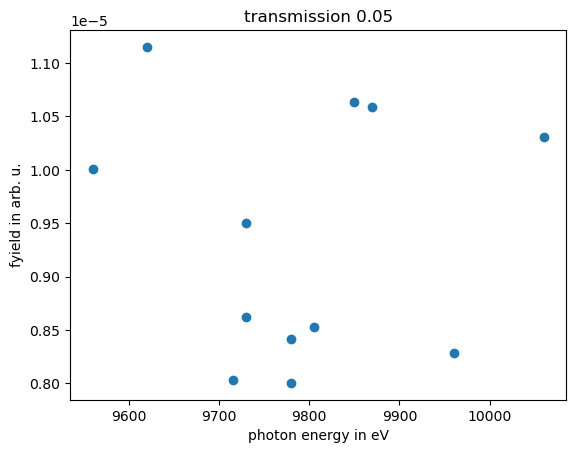

[0.18442757945600102, 0.1909681674740963, 0.1909681674740963, 0.20352655508810374, 0.21691130777589546, 0.21691130777589546, 0.2311650434639025, 0.2311650434639025, 0.2311650434639025, 0.24636741809009102, 0.26256895352272935]


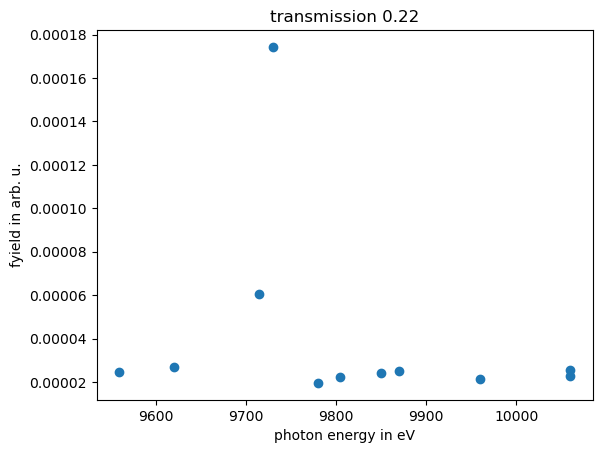

[0.8260715720784916, 0.8260715720784916, 0.8803974741206089, 0.8803974741206089, 0.8803974741206089]


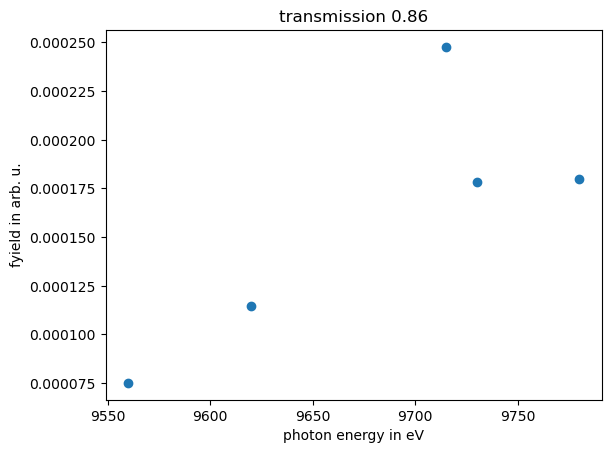

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


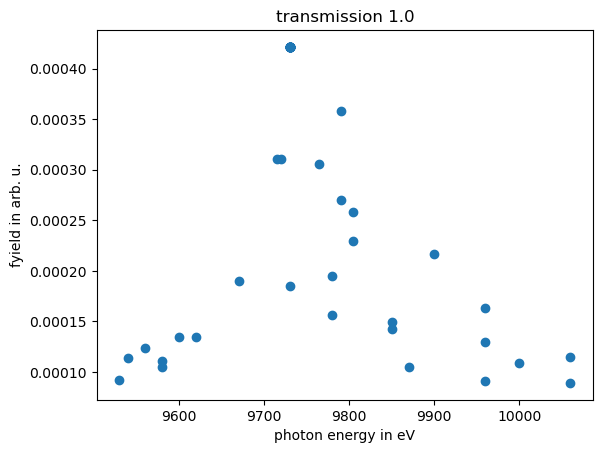

In [13]:
import sys
sys.path.append('/gpfs/exfel/exp/SPB/202501/p006933/usr/Software/analysistools')
import data_helper as dh
import focus_scan as fs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
from scipy.interpolate import interp1d

path = dh.expPath+'Results/FocusScans/Data/'
directory=Path(path)

runs = np.arange(167, 223)
format_runs = [dh.run_format(r) for r in runs]
#print(format_runs)


files = [file.name for file in sorted(directory.glob('fyield_*n300.h5'), reverse=False) if int(file.name.split('_')[1][1:5]) in runs]

nshot=files[0].split('_')[5][1:4]

f_yield = []
for file in files:
    df = pd.read_hdf(path+file, ignore_index=True)
    f_yield.append(df)

df = pd.concat(f_yield, ignore_index=True)
print(df.columns)

df_sorted=df.sort_values(by='transmission')
threshold=0.06
# Listen zur Speicherung der gruppierten Daten
grouped_transmissions = []
grouped_f = []
grouped_photon_energy = []

# Initialisiere die erste Gruppe mit dem ersten Eintrag
current_group_trans = [df_sorted.iloc[0]['transmission']]
current_group_f = [df_sorted.iloc[0]['f_yield']]
current_group_photon_energy = [df_sorted.iloc[0]['photon_energy']]

# Iteriere über alle Zeilen (ab dem zweiten Eintrag)
for i in range(1, len(df_sorted)):
    # Vergleiche den aktuellen Transmission-Wert mit dem letzten Wert der aktuellen Gruppe
    if abs(df_sorted.iloc[i]['transmission'] - current_group_trans[-1]) < threshold:
        # Wenn die Differenz innerhalb des Schwellwerts liegt, füge alle Werte der aktuellen Gruppe hinzu
        current_group_trans.append(df_sorted.iloc[i]['transmission'])
        current_group_f.append(df_sorted.iloc[i]['f_yield'])
        current_group_photon_energy.append(df_sorted.iloc[i]['photon_energy'])
    else:
        # Wenn die Transmission zu weit entfernt ist, speichere die bisherige Gruppe und starte eine neue
        grouped_transmissions.append(current_group_trans)
        grouped_f.append(current_group_f)
        grouped_photon_energy.append(current_group_photon_energy)
        
        current_group_trans = [df_sorted.iloc[i]['transmission']]
        current_group_f = [df_sorted.iloc[i]['f_yield']]
        current_group_photon_energy = [df_sorted.iloc[i]['photon_energy']]

# Füge die letzte Gruppe hinzu
grouped_transmissions.append(current_group_trans)
grouped_f.append(current_group_f)
grouped_photon_energy.append(current_group_photon_energy)

# Erstelle einen DataFrame mit den gruppierten Daten
grouped_df = pd.DataFrame({
    'Grouped transmissions': grouped_transmissions,
    'fyield': grouped_f,
    'photon_energy': grouped_photon_energy
})

for index in range(len(grouped_df['fyield'])):
    print(grouped_df['Grouped transmissions'][index])
    plt.plot(grouped_df['photon_energy'][index],grouped_df['fyield'][index], ls='', marker='o')
    plt.title(f'transmission {round(np.mean(grouped_df["Grouped transmissions"][index]), 2)}')
    plt.xlabel('photon energy in eV')
    plt.ylabel('fyield in arb. u.')
    plt.savefig(f'/gpfs/exfel/exp/SPB/202501/p006933/usr/Shared/muthreich/fyield_{round(np.mean(grouped_df["Grouped transmissions"][index]), 2)}.png', format='png')
    plt.show()
